In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import random

In [2]:
%load_ext autoreload
%autoreload 2
from base import utils, datahandler, prediction_models, evaluation

In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

In [7]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

In [5]:
# get all labels in the dataframes
keys_list = list(split_dataframes.keys())
random.Random(69).shuffle(keys_list) # shuffle, but with a seed for reproducability
split_idx = int(len(keys_list) * 0.8)
train_keys = keys_list[:split_idx]
train_labels_EW = []
train_labels_NS = []
val_keys = keys_list[split_idx:]
val_labels_EW = []
val_labels_NS = []
for key in train_keys:
    train_labels_EW += list(split_dataframes[key]['EW'].unique())
    train_labels_NS += list(split_dataframes[key]['NS'].unique())
for key in val_keys:
    val_labels_EW += list(split_dataframes[key]['EW'].unique())
    val_labels_NS += list(split_dataframes[key]['NS'].unique())
train_labels_EW = list(dict.fromkeys(train_labels_EW))
train_labels_NS = list(dict.fromkeys(train_labels_NS))
val_labels_EW = list(dict.fromkeys(val_labels_EW))
val_labels_NS = list(dict.fromkeys(val_labels_NS))
print(train_labels_EW)
print(val_labels_EW)
print(train_labels_NS)
print(val_labels_NS)


['SS-CK', 'SS-HK', 'SS-EK']
['SS-CK', 'SS-HK']
['SS-NK', 'IK-CK', 'SS-CK', 'SS-HK', 'IK-HK']
['SS-NK', 'IK-CK', 'SS-HK']


In [9]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features, train_val_split=0.85, stride=1, input_steps=8, seed=69)

Creating dataset from 212 train and 38 val objects
Creating datasets with labels ['EW', 'EW_Node', 'EW_Type', 'NS', 'NS_Node', 'NS_Type']
Created datasets with seed 69


In [ ]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW'], shuffle=True)
train_NS, val_NS = ds_gen.get_datasets(128, label_features=['NS'], shuffle=True)
#dense_model_ew = prediction_models.Dense_NN(train_EW, dense_layers=[512,256,32], l2_reg=0.0001, mixed_dropout=0.2)
#dense_model_ns = prediction_models.Dense_NN(train_EW, dense_layers=[512,256,32], l2_reg=0.0001, mixed_dropout=0.2)
dense_model_ew = prediction_models.Dense_NN(train_EW, dense_layers=[512,512], l2_reg=0.001, mixed_dropout=0.0, seed=0)
dense_model_ns = prediction_models.Dense_NN(train_NS, dense_layers=[512,512], l2_reg=0.00, mixed_dropout=0.0, seed=0)
print("Training model #1")
hist_ew = dense_model_ew.fit(train_EW, val_ds=val_EW, epochs=40, verbose=0, plot_hist=False) # TODO: somehow this sometimes has save_best_only enabled?? even though its only enabled in 2nd fit? ... do inherited models somehow modify the mother class?!?
print("Training model #2")
hist_ns = dense_model_ns.fit(train_NS, val_ds=val_NS, epochs=40, verbose=0, plot_hist=False)
print("EW results:")
dense_model_ew.model.evaluate(train_EW)
dense_model_ew.model.evaluate(val_EW)
print("NS results:")
dense_model_ns.model.evaluate(train_NS)
dense_model_ns.model.evaluate(val_NS)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 8, 15)]              0         []                            
                                                                                                  
 conv1d_9 (Conv1D)           (None, 8, 128)               5888      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 8, 128)               512       ['conv1d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 re_lu_9 (ReLU)              (None, 8, 128)               0         ['batch_normalization_9

c:\Code\ARCLab Challenge\splid-challenge\base\prediction_models.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


903/903 [==============================] - 16s 12ms/step - loss: 0.1821 - EW_loss: 0.0610 - NS_loss: 0.1086 - EW_accuracy: 0.9751 - NS_accuracy: 0.9549


[0.18207648396492004,
 0.06103590875864029,
 0.10858946293592453,
 0.9751238226890564,
 0.9549245834350586]

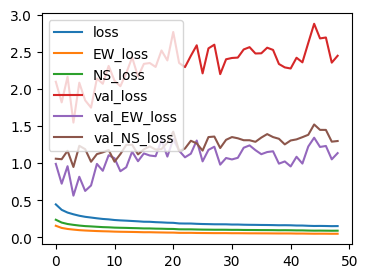

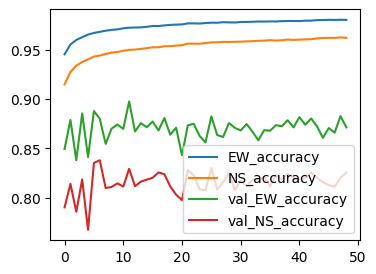

In [27]:
train_combined, val_combined = ds_gen.get_datasets(512, label_features=['EW', 'NS'], shuffle=True)
dense_combined_model = prediction_models.CNN(train_combined, conv_layers=[128,128,128], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
dense_combined_model.summary()
hist = dense_combined_model.fit(train_combined, val_ds=val_combined, target_metric='loss', epochs=50, verbose=1, plot_hist=False, save_best_only=True)
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])
dense_combined_model.evaluate(train_combined)

In [ ]:
# TODO: find out if we can directly train for precision/challenge metrics
# TODO: maybe it makes sense to look at values before and after the node? Given that we are trying to detect changes...
# TODO: check if train_NS even contains all the labels in val_NS... in general, train should contain all labels
# TODO: Make sure labelencoder gets saved
# TODO: some of the features cross sign boundaries -> feature engineering necessary!
# TODO: for some reason, phase_1 ds is missing objects... maybe they have to be combined with warmup ones? Also features changed..

In [16]:
def prepare_submission_df(ds, model, model_output_features, label_decoders):
    '''Prepare dataframes for submission based on models predictions. The output_labels need to be in the same order as they were when creating the dataset!'''
    assert(len(model_output_features) == len(label_decoders))
    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])
    
    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)

    preds = model.predict(inputs)
    for ft_idx, feature in enumerate(model_output_features):
        labels = np.concatenate([element[feature] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
        labels_decoded = label_decoders[ft_idx].inverse_transform(labels)
        preds_argmax = np.argmax(preds[ft_idx], axis=1) if len(model_output_features)>1 else np.argmax(preds, axis=1)
        preds_decoded = label_decoders[ft_idx].inverse_transform(preds_argmax)
        df[f'{feature}'] = labels_decoded
        df[f'Predicted_{feature}'] = preds_decoded
    return df


In [21]:
ground_truth = pd.read_csv(challenge_data_dir / 'train_labels.csv')
ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.train_keys))].copy()
ground_truth_val = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.val_keys))].copy()

In [28]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_train=prepare_submission_df(ds=train_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'], label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder])
smoothed_df_train = utils.smooth_predictions(df_train, past_steps=3, fut_steps=10)
train_results = utils.convert_classifier_output(smoothed_df_train).sort_values(['ObjectID']).reset_index(drop=True)
print(len(train_results))
# print(train_results.sort_values(['ObjectID', 'TimeIndex', 'Direction']).head(50))
print(len(ground_truth_train))
# print(ground_truth_train.sort_values(['ObjectID', 'TimeIndex', 'Direction']).head(50))
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_train, train_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the train set: {precision:.2f}')
print(f'Recall for the train set: {recall:.2f}')
print(f'F2 for the train set: {f2:.2f}')
print(f'RMSE for the train set: {rmse:.2f}')

# TODO: predict on val with simly ss node and predict engine type... might give quite high precision?
# Dense result: F2 0.49/0.32 (t/v)

14439/14439 [==============================] - 43s 3ms/step


Smoothing: 100%|██████████| 212/212 [03:47<00:00,  1.07s/it]


2278
958
Precision for the train set: 0.26
Recall for the train set: 0.63
F2 for the train set: 0.49
RMSE for the train set: 1.91


In [29]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_val=prepare_submission_df(ds=val_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'], label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder])
smoothed_df_val = utils.smooth_predictions(df_val, past_steps=3, fut_steps=10)
val_results = utils.convert_classifier_output(smoothed_df_val).sort_values(['ObjectID']).reset_index(drop=True)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_val, val_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the val set: {precision:.2f}')
print(f'Recall for the val set: {recall:.2f}')
print(f'F2 for the val set: {f2:.2f}')
print(f'RMSE for the val set: {rmse:.2f}')


2588/2588 [==============================] - 8s 3ms/step


Smoothing: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]


Precision for the val set: 0.11
Recall for the val set: 0.59
F2 for the val set: 0.32
RMSE for the val set: 1.48


In [288]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW'], shuffle=False, keep_identifier=True)
train_NS, val_NS = ds_gen.get_datasets(128, label_features=['NS'], shuffle=False, keep_identifier=True)
df_EW = prepare_submission_df(ds=train_EW, model=dense_model_ew.model, model_output_features=['EW'], label_decoders=[ds_gen.combined_label_encoder])
df_NS = prepare_submission_df(ds=train_NS, model=dense_model_ns.model, model_output_features=['NS'], label_decoders=[ds_gen.combined_label_encoder])
combined_df = df_EW
combined_df['NS'] = df_NS['NS']
combined_df['Predicted_NS'] = df_NS['Predicted_NS']
smoothed_df_val = utils.smooth_predictions(combined_df)
train_results = utils.convert_classifier_output(smoothed_df_val).sort_values(['ObjectID']).reset_index(drop=True)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_train, train_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the train set: {precision:.2f}')
print(f'Recall for the train set: {recall:.2f}')
print(f'F2 for the train set: {f2:.2f}')
print(f'RMSE for the train set: {rmse:.2f}')

1019/1019 [==============================] - 2s 2ms/step


Smoothing: 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


Precision for the train set: 0.65
Recall for the train set: 0.65
F2 for the train set: 0.65
RMSE for the train set: 0.58
